# Influence functions for data mis-labelling

Both data mis-labelling and outlier detection target the same problem, they are operating on discrete and continuous values, respectively. A influence function $I(x_1, x_2) \colon \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R} $ measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$. As long as the loss function $L(x, y)$ is differentiable (or can be approximated by a surrogate objective). Imagine a simple classification problem, where $y_i \in \{1, \dots, K\}$, the goal is now to find labels which are mislabelled.

## Artificial data generation

First we generate a K-class, M-dimensional dataset using a Gaussian mixture model (GMM). This can be done by sampling $N$ data points from a discrete distribution.

In [2]:
from valuation.utils import Dataset
from sklearn.model_selection import train_test_split

import numpy as np

N = 1000
K = 2
M = 2
sigma = 0.2

gaussian_mean = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])
gaussian_cov = sigma * np.eye(M)
gaussian_chol = np.linalg.cholesky(gaussian_cov)
y = np.random.randint(K, size=N)
x = np.einsum('ij,kj->ki', gaussian_chol, np.random.normal(size=[N, M])) + gaussian_mean[y]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70)
dataset = Dataset(
    x_train,
    y_train,
    x_test,
    y_test
)

## Plotting the training and the test data

In the following we plot the training as well as the test set side by side.

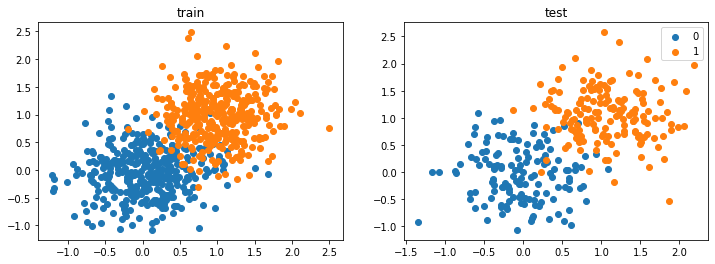

In [3]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()

## Calculating linear influences using logistic regression

In this section we utilize a logistic regression model to identify wrongly labelled data samples. As a first step one needs to define a model, fit it to the data and then insert it in the influence function

In [5]:
from valuation.models.pytorch_model import PyTorchSupervisedModel
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

objective = F.binary_cross_entropy
model = PyTorchSupervisedModel(model=BinaryLogisticRegressionTorchModel(M), objective=F.binary_cross_entropy)
model.fit(
    dataset.x_train,
    dataset.y_train
)

data_influences = influences(
    model,
    dataset,
    influence_type=InfluenceTypes.Up
)
data_influences

Training loss: 0.6875791549682617
Training loss: 0.6861724853515625
Training loss: 0.6857374906539917
Training loss: 0.6868718862533569
Training loss: 0.68575119972229
Training loss: 0.6845595836639404
Training loss: 0.6840645670890808
Training loss: 0.6847894787788391
Training loss: 0.6836442947387695
Training loss: 0.6834543347358704
Training loss: 0.6823006868362427


array([[ 0.75990975,  0.37941074, -0.59374   , ..., -3.3596272 ,
        -3.0398633 , -3.161271  ],
       [-1.1211892 , -3.4038866 ,  0.91624707, ...,  0.03483411,
         1.1794398 , -2.7257075 ],
       [-1.1005628 , -3.9393075 ,  0.7820155 , ...,  0.45234764,
         1.8310927 , -3.1545472 ],
       ...,
       [-0.9784341 , -6.8021574 ,  0.03673697, ...,  2.8344808 ,
         5.46112   , -5.355093  ],
       [ 0.7213123 , -0.46903563, -0.6501014 , ..., -3.4894114 ,
        -2.7807646 , -4.315913  ],
       [ 0.92344844,  0.52192664, -0.9249605 , ..., -1.6379018 ,
        -1.4202564 , -1.9529207 ]], dtype=float32)


## Calculating linear influences using logistic regression

